In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
import scipy.interpolate
import numpy
import glob
%matplotlib notebook

In [52]:
r_beam, wavelength, r_mean, r_meadian, r_std, counts = np.loadtxt("step4.dat", unpack=1)

<IPython.core.display.Javascript object>


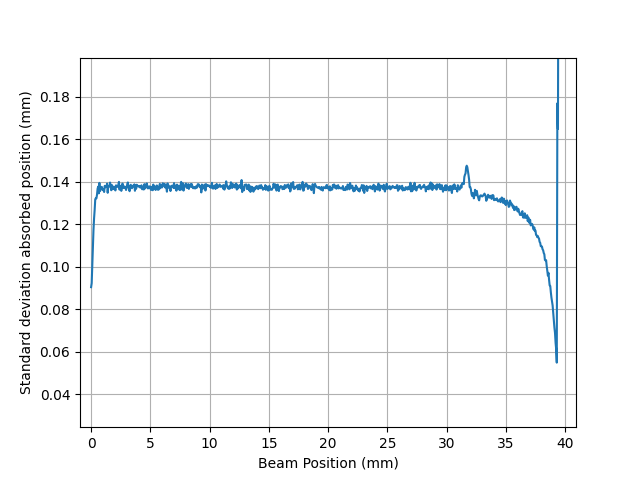

In [54]:
# The standard deviation of the position should be approximately the beam width. At the edges things go crazy due to total internal reflections
plt.figure()
plt.plot(r_beam[counts>10], r_std[counts>10])
plt.ylabel("Standard deviation absorbed position (mm)")
plt.xlabel("Beam Position (mm)")
plt.grid()

<IPython.core.display.Javascript object>


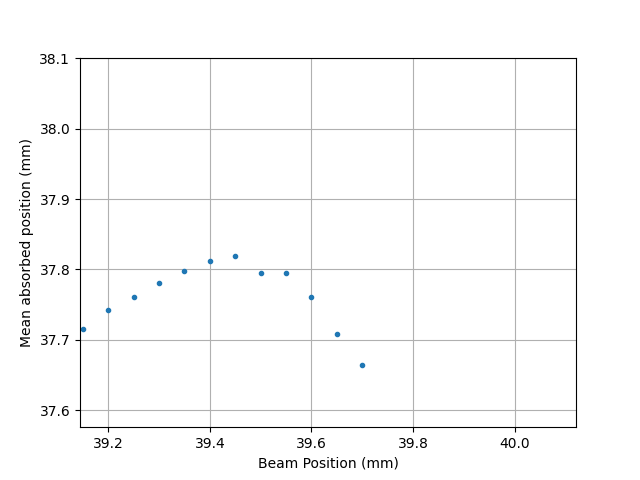

/data/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/polynomial.py:658: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/data/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/data/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>


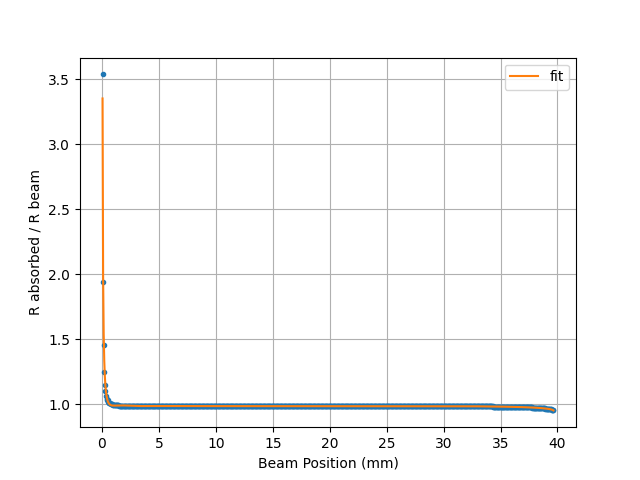

/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


In [60]:
# We fit with polynomial the difraction
plt.figure()
plt.plot(r_beam[counts>0], r_mean[counts>0],'.')
plt.ylabel("Mean absorbed position (mm)")
plt.xlabel("Beam Position (mm)")
plt.grid()


rlim = 39.7
mask = np.logical_and(counts>0, r_beam<rlim)
z = np.polyfit(r_beam[mask],r_mean[mask], 155)
p = np.poly1d(z)

plt.figure()
plt.plot(r_beam[mask],r_mean[mask]/r_beam[mask], '.')
plt.plot(r_beam[mask], p(r_beam[mask])/r_beam[mask], label = "fit")
plt.legend()
plt.ylabel("R absorbed / R beam")
plt.xlabel("Beam Position (mm)")
plt.grid()

/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


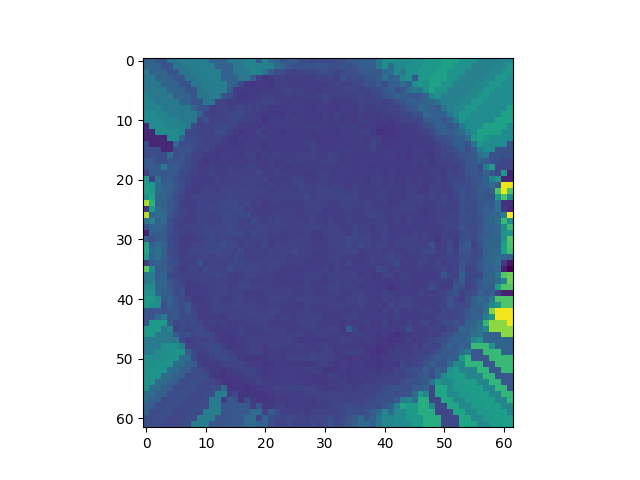

<IPython.core.display.Javascript object>


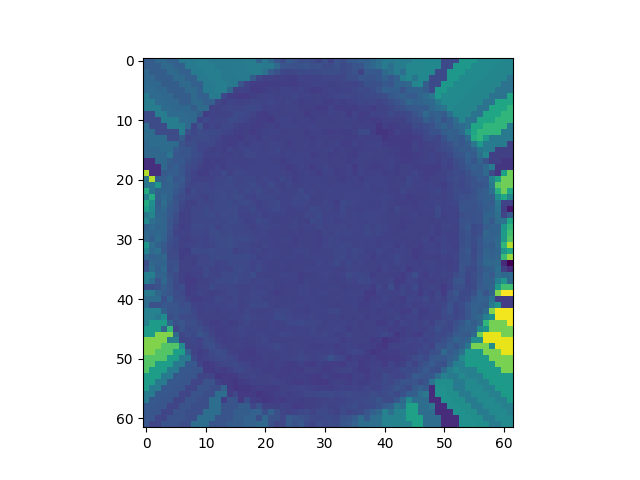

<IPython.core.display.Javascript object>


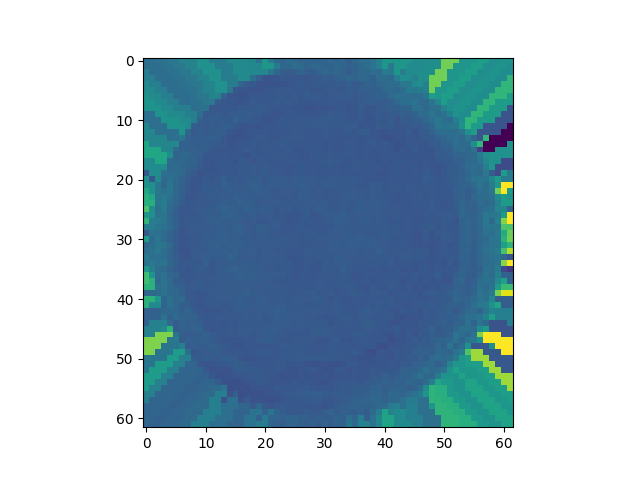

<IPython.core.display.Javascript object>


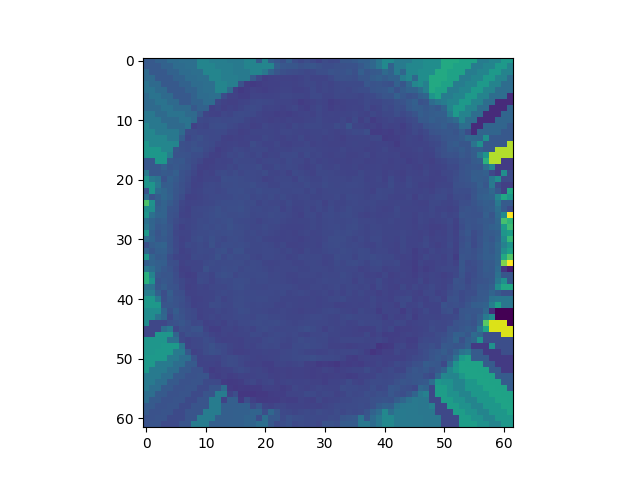

<IPython.core.display.Javascript object>


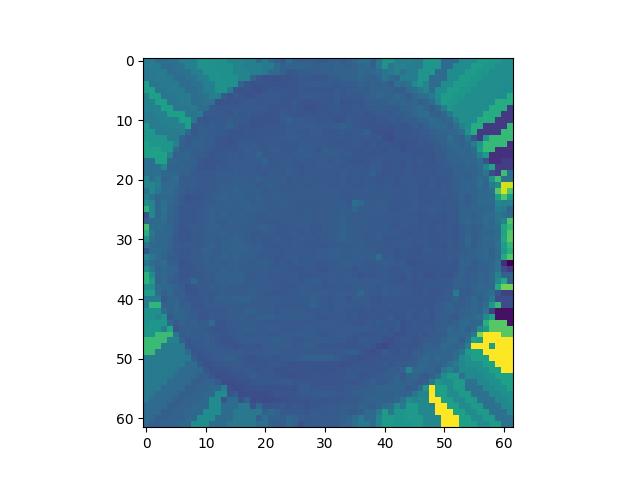

<IPython.core.display.Javascript object>


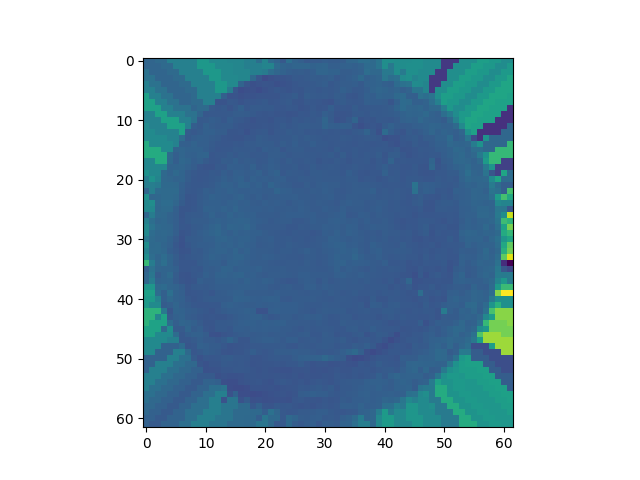

<IPython.core.display.Javascript object>


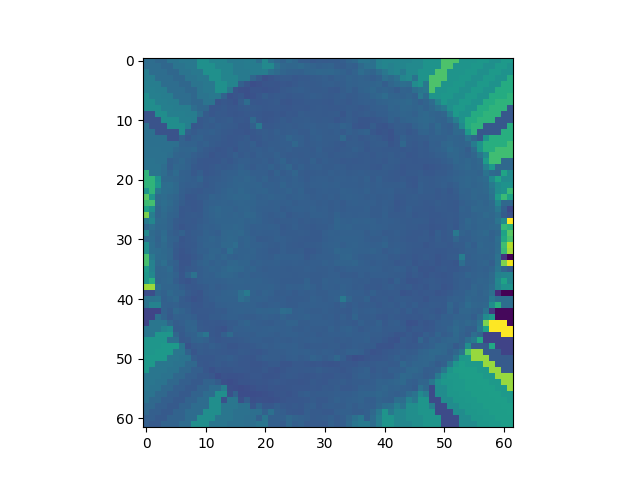

<IPython.core.display.Javascript object>


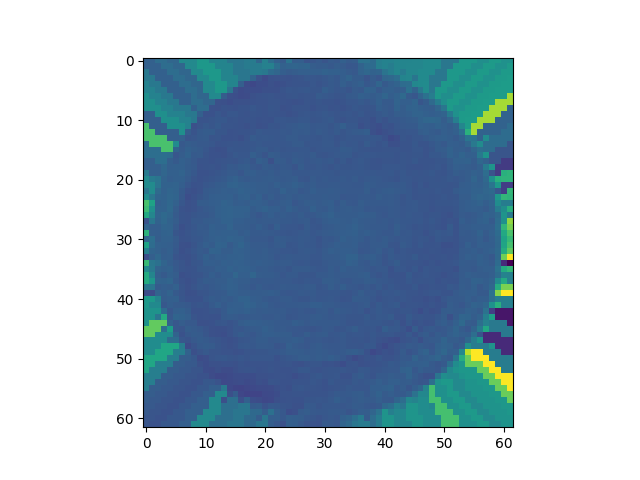

<IPython.core.display.Javascript object>


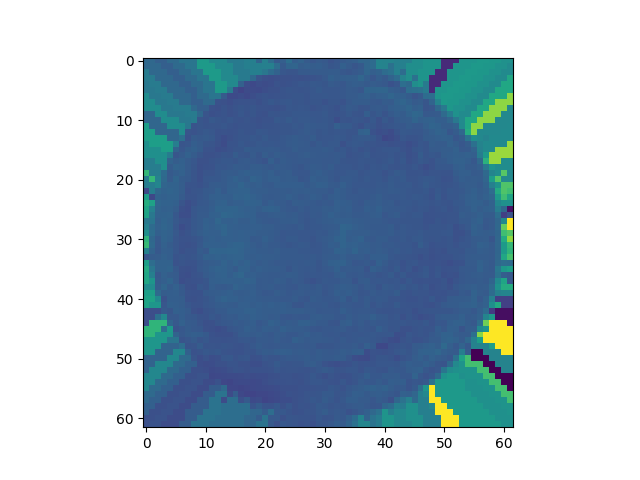

<IPython.core.display.Javascript object>


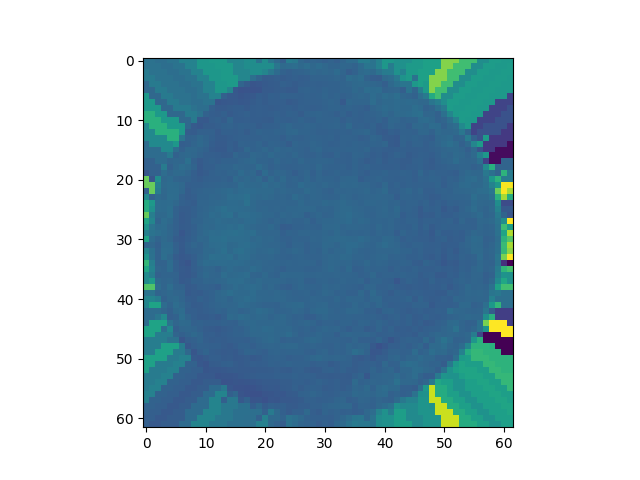

<IPython.core.display.Javascript object>


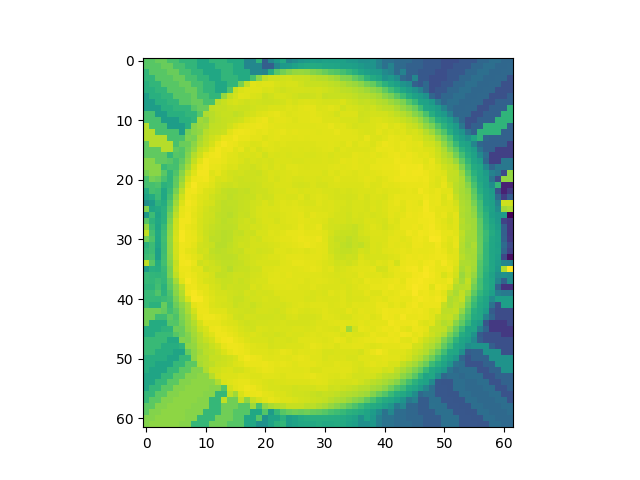

<IPython.core.display.Javascript object>


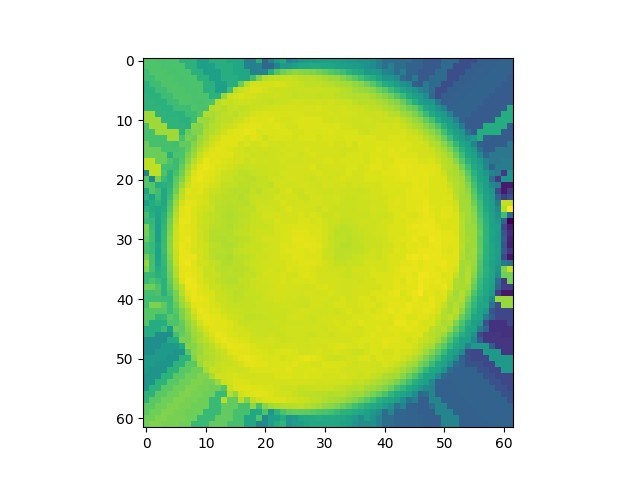

<IPython.core.display.Javascript object>


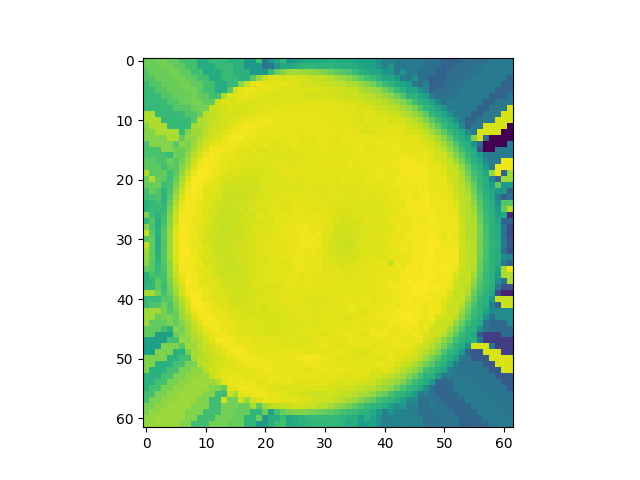

<IPython.core.display.Javascript object>


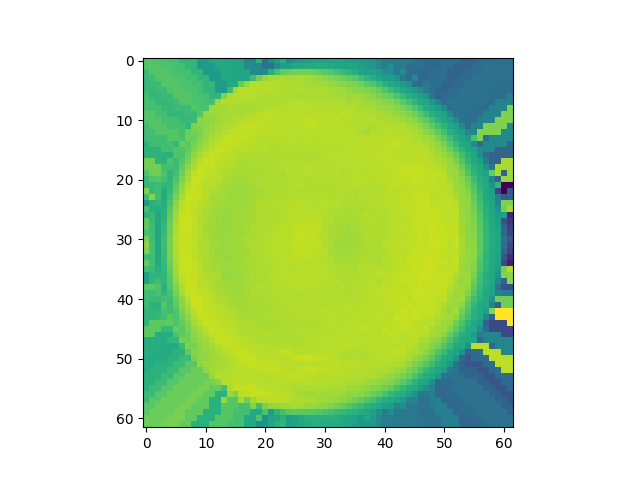

<IPython.core.display.Javascript object>


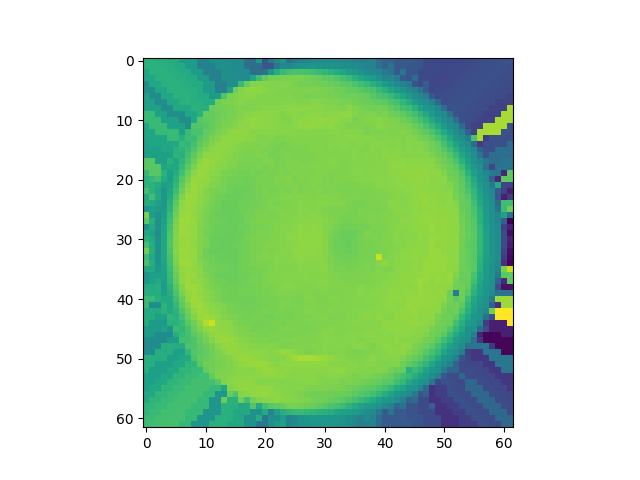

<IPython.core.display.Javascript object>


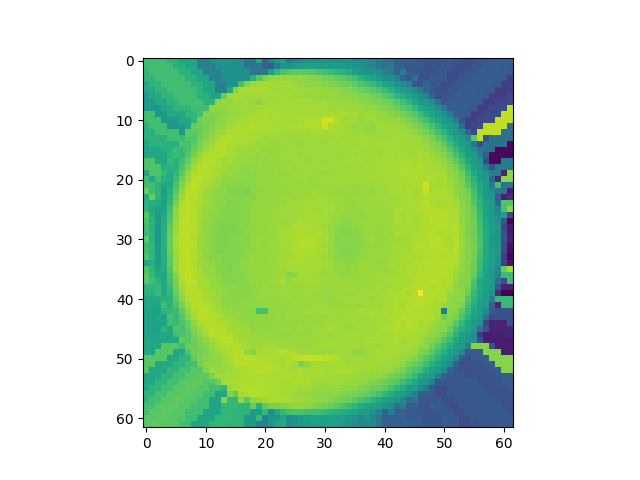

<IPython.core.display.Javascript object>


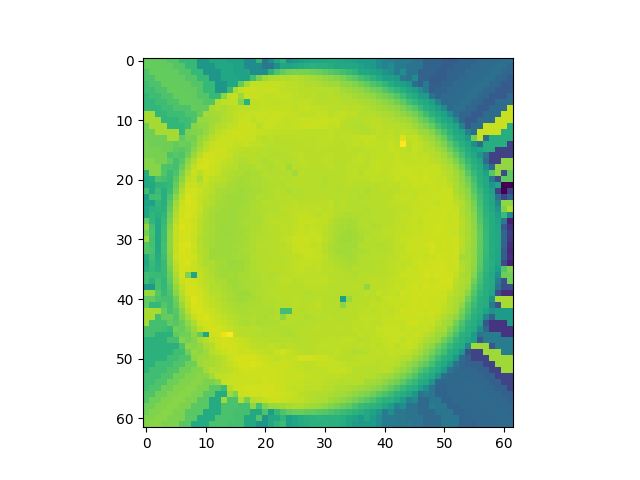

<IPython.core.display.Javascript object>


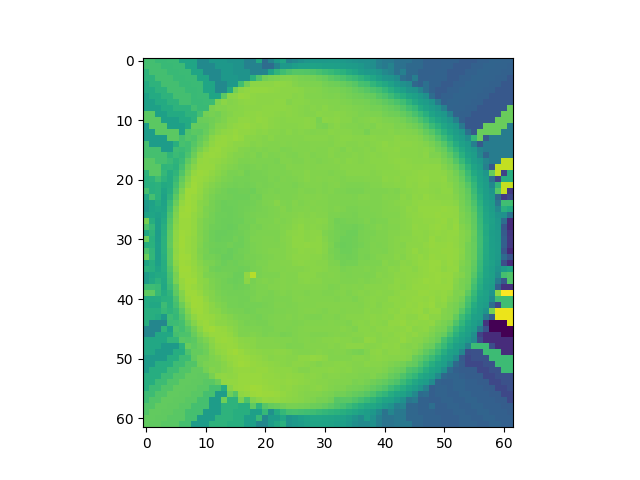

/data/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


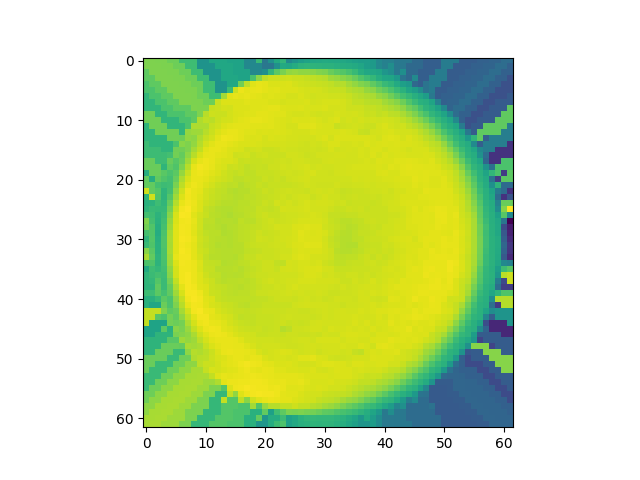

<IPython.core.display.Javascript object>


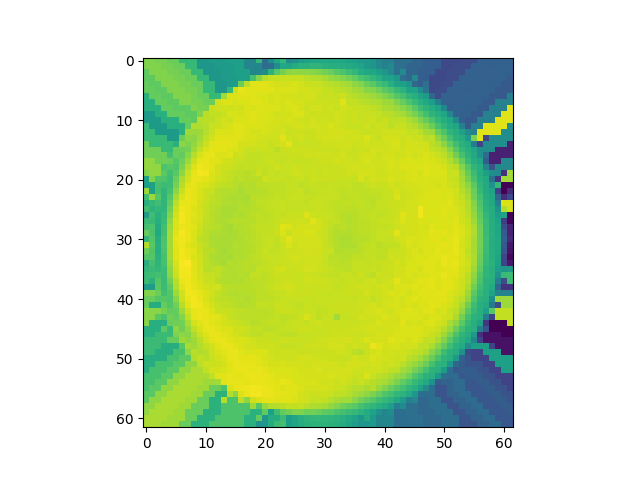

<IPython.core.display.Javascript object>


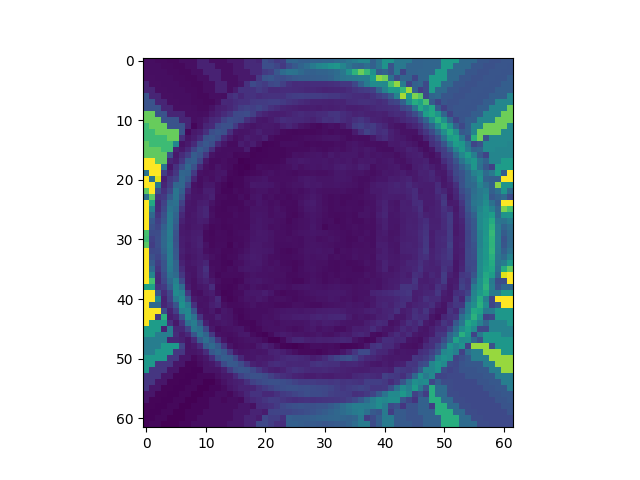

<IPython.core.display.Javascript object>


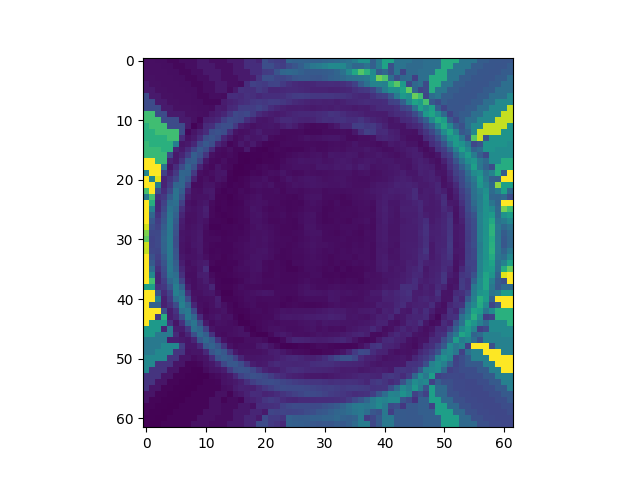

<IPython.core.display.Javascript object>


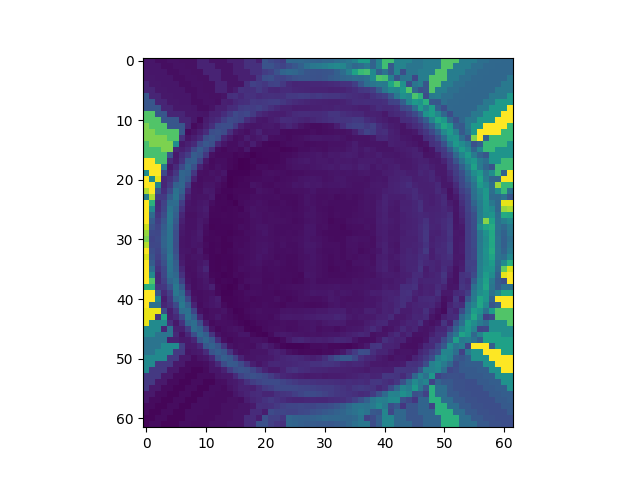

<IPython.core.display.Javascript object>


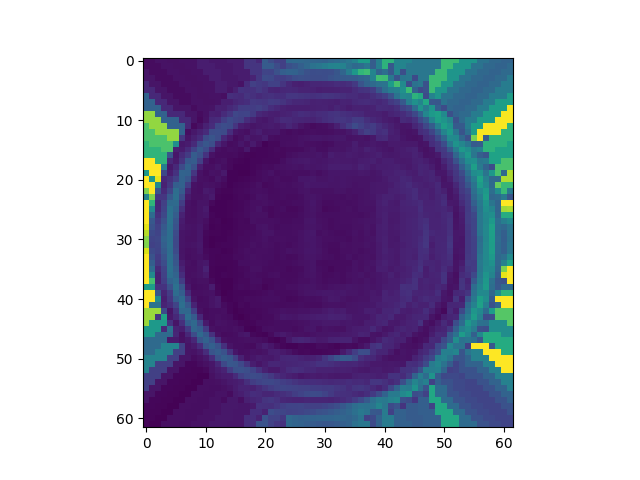

<IPython.core.display.Javascript object>


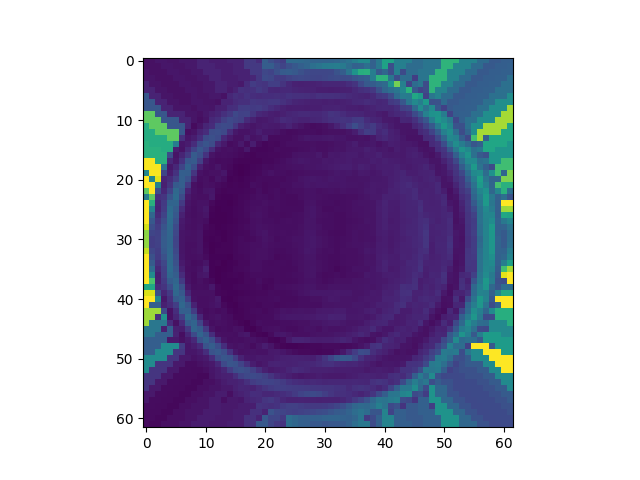

<IPython.core.display.Javascript object>


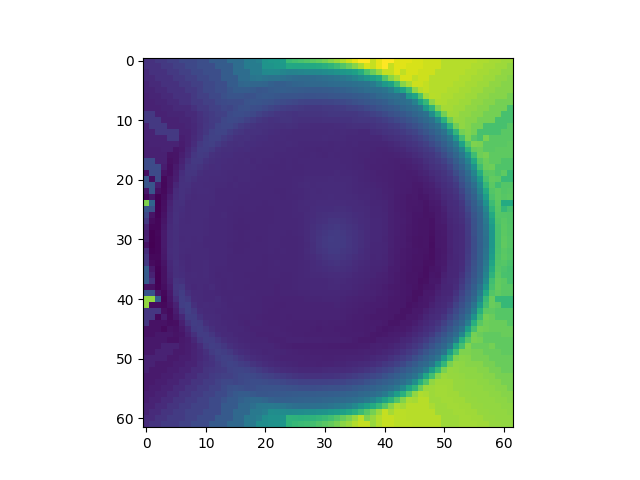

<IPython.core.display.Javascript object>


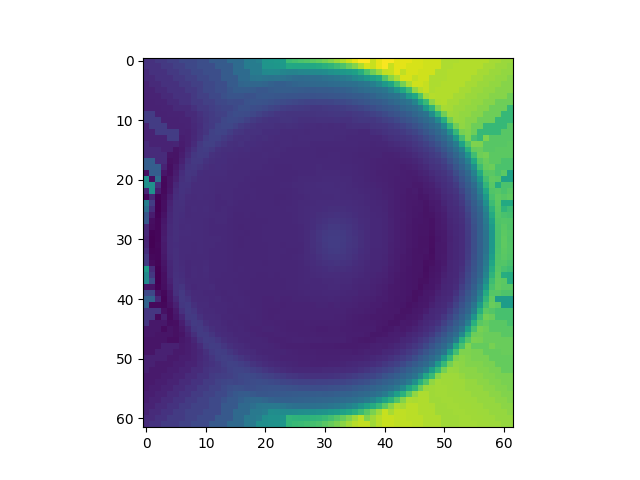

<IPython.core.display.Javascript object>


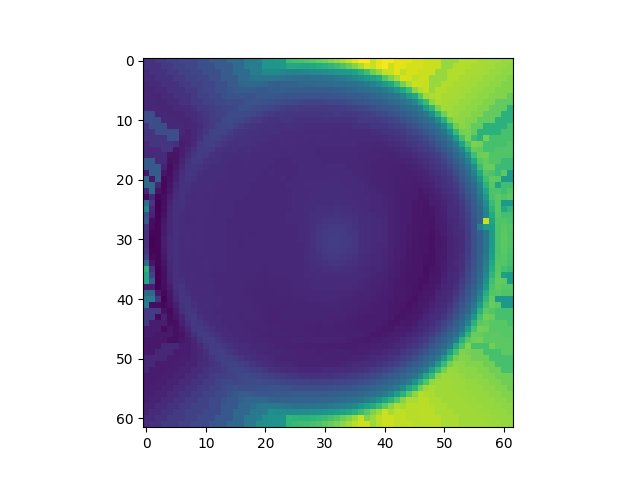

<IPython.core.display.Javascript object>


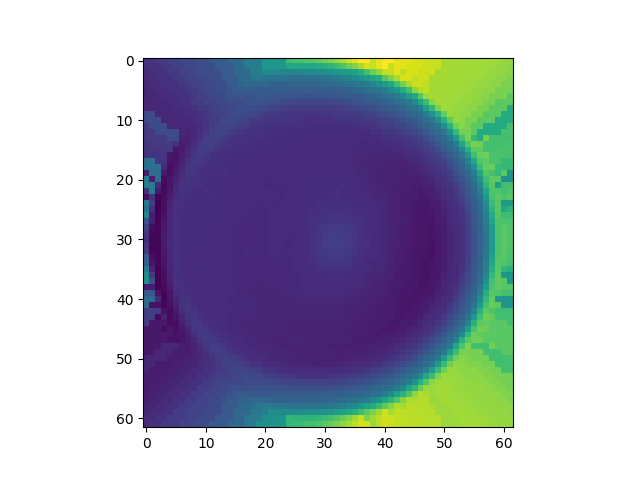

<IPython.core.display.Javascript object>


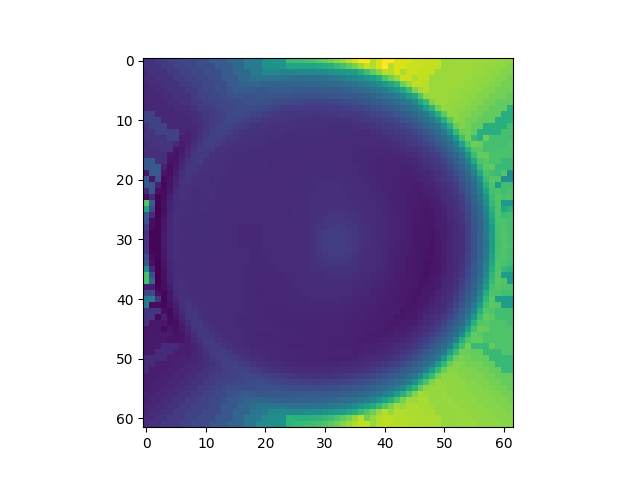

<IPython.core.display.Javascript object>


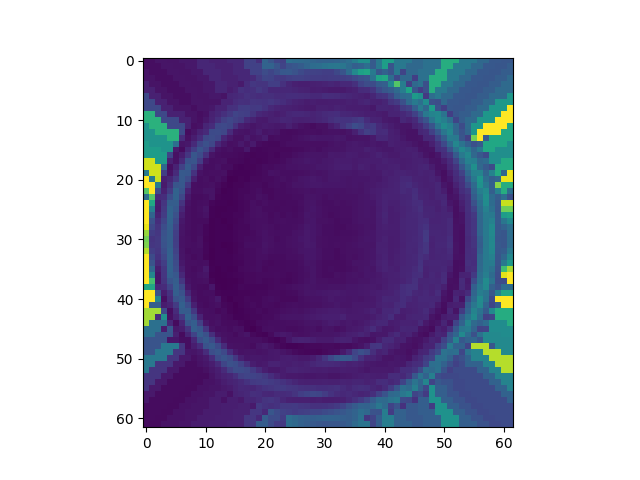

<IPython.core.display.Javascript object>


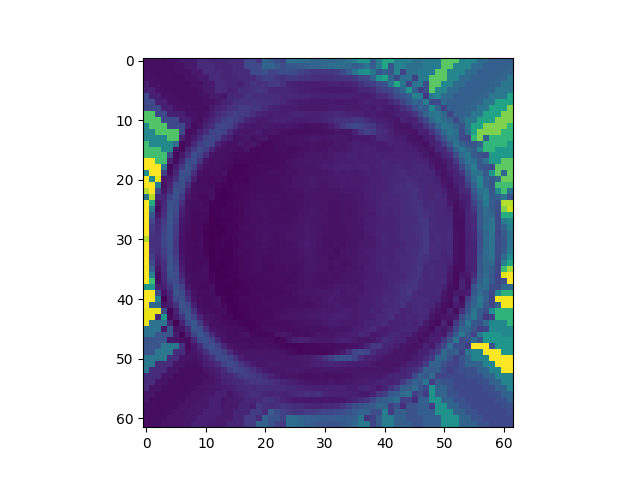

<IPython.core.display.Javascript object>


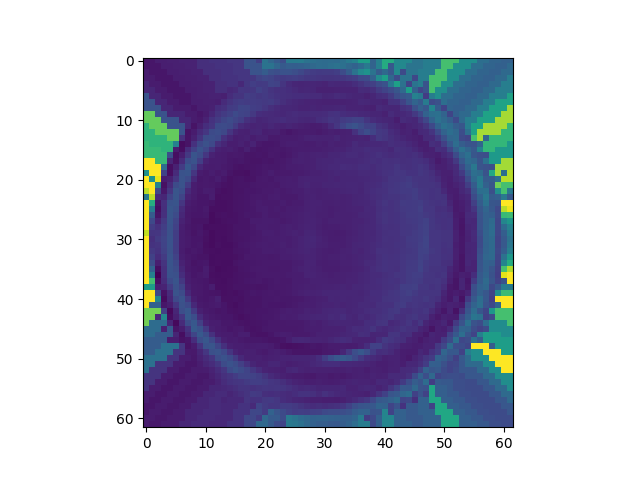

<IPython.core.display.Javascript object>


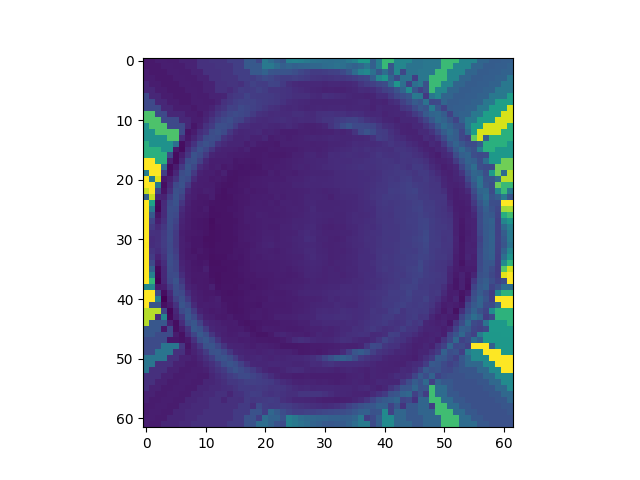

<IPython.core.display.Javascript object>


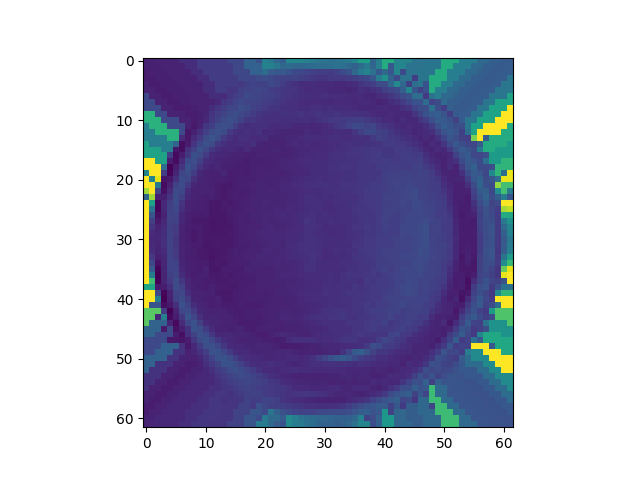

<IPython.core.display.Javascript object>


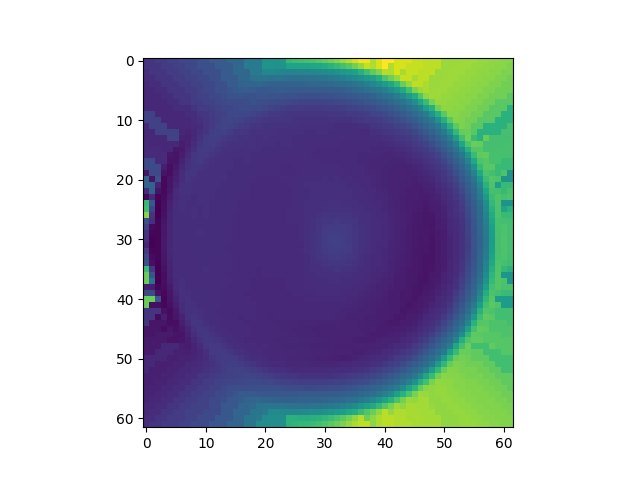

<IPython.core.display.Javascript object>


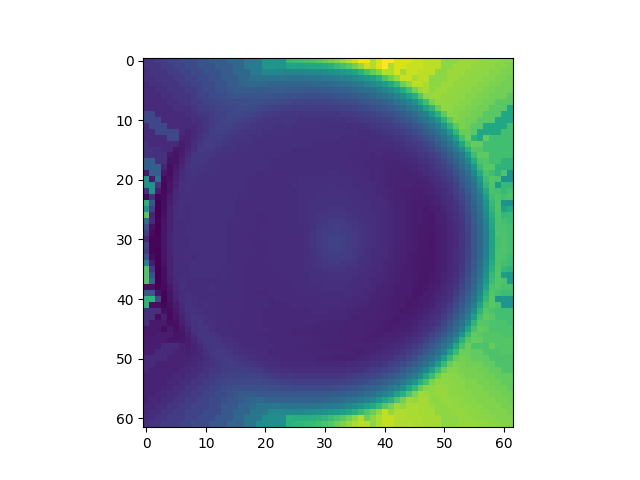

<IPython.core.display.Javascript object>


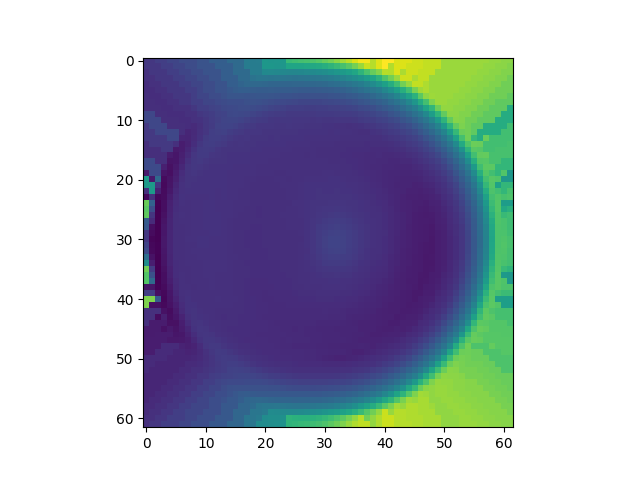

<IPython.core.display.Javascript object>


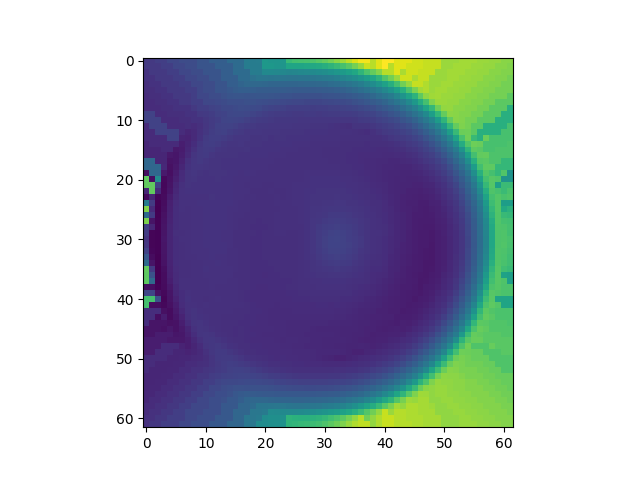

<IPython.core.display.Javascript object>


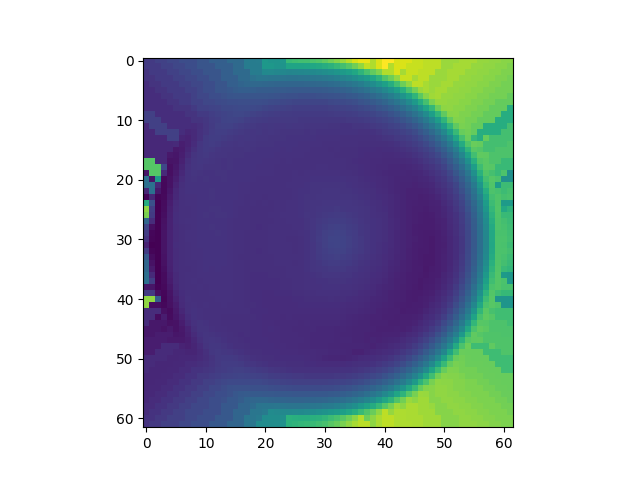

In [63]:

class LinearNDInterpolatorExt(object):
    def __init__(self, points,values):
        self.funcinterp=scipy.interpolate.LinearNDInterpolator(points,values)
        self.funcnearest=scipy.interpolate.NearestNDInterpolator(points,values)
    def __call__(self,*args):
        t=self.funcinterp(*args)
        if not numpy.isnan(t):
            return t.item(0)
        else:
            return self.funcnearest(*args)

bounds = {
    "SPEresolution" : {"posdef" : True, "min" : 0.1, "max" : 0.9},
    "Gain" : {"posdef" : True, "min" : 0, "max" : 1.25},
    "TransitTimeSpread" : {"posdef" : True, "min" : 0.5 , "max" :2.5},
    "TransitTime" : {"posdef" : False, "min": -2 , "max" :9}
}


def CheckValue(key, val):
    if bounds[key]["posdef"]:
        val = abs(val)
    if val < bounds[key]["min"]:
        val = bounds[key]["min"]
    if val > bounds[key]["max"]:
        val = bounds[key]["max"]
    return val
    
def scaleXY(polynome, fname):
    x, y, vals = np.loadtxt(f"original/{fname}", unpack=1)
    
    R = np.sqrt(x**2+y**2)
    mask = R <= 39.7
    
    x = x[mask]
    y = y[mask]
    vals = vals[mask]
    R = R[mask]
    Rs = polynome(R)
    factor = Rs/R
    
    for i, f in enumerate(factor):
        if f==0. or np.isnan(f) or np.isinf(f):
            factor[i] = 1.
    
    key = fname.split("_")[0]

    x *= factor
    y *= factor
    for i,val in enumerate(vals):
        vals[i] = CheckValue(key, val)
    finterp = LinearNDInterpolatorExt((x,y), vals)
    step = 1.25
    
    # here put a number a bit larger than the maximal R possible in the simulation, for example mDOM PMT jEllipseXYaxis =37.8704
    xx = np.arange(-37.9, 37.9+step, step) 
    vals_interpolated = []
    xinterp = []
    yinterp = []
    rs = []
    matrix = np.zeros((xx.size,xx.size))
    for i,xi in enumerate(xx):
        for j,yi in enumerate(xx):
            svl = finterp(xi, yi)
            vals_interpolated.append(svl)
            matrix[i][j]= svl
            rs.append(np.sqrt(xi**2+yi**2))
            xinterp.append(xi)
            yinterp.append(yi)
            
    vals_interpolated = np.array(vals_interpolated)
    xinterp = np.array(xinterp)
    yinterp = np.array(yinterp)
    plt.figure()
    plt.imshow(matrix)
    with open(f"modified_regulargrid/{fname}", "w") as file:
        for xi, yi, vali in zip(xinterp, yinterp, vals_interpolated):
            vl = CheckValue(key, vali)
            file.write(f"{round(xi,2)}\t{round(yi,2)}\t{vl}\n")
            
    return R,factor

for file in glob.glob("original/*"):
    try:
        R,fctor = scaleXY(p, file.split("/")[-1])
        
    except Exception as err:
        print(file, err)

# Check simulation output

In [90]:
x,y,_,gain,spe_res,transit_time,TTS,_ = np.loadtxt("step5.dat", unpack=1)

<IPython.core.display.Javascript object>


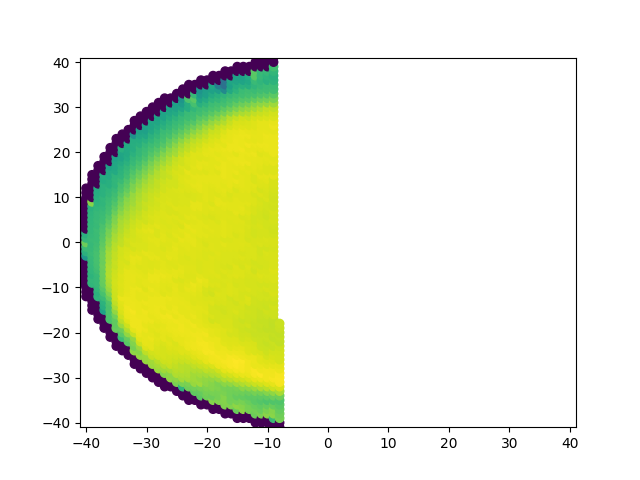

(-41.0, 41.0)

In [91]:
plt.figure()
plt.scatter(x,y,c=gain)
plt.xlim(-41,41)
plt.ylim(-41,41)

<IPython.core.display.Javascript object>


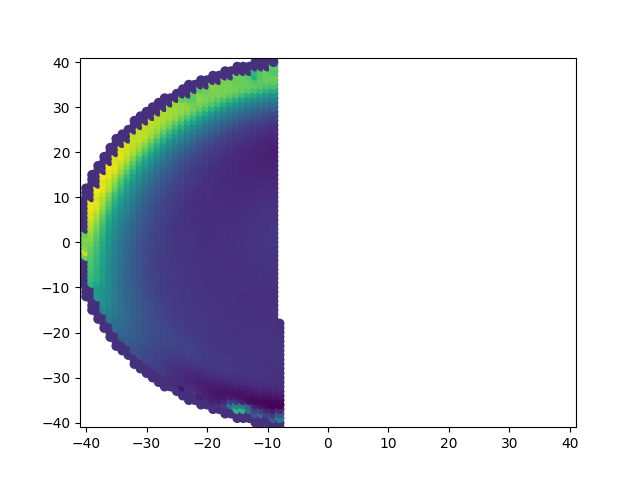

(-41.0, 41.0)

In [92]:
plt.figure()
plt.scatter(x,y,c=transit_time)
plt.xlim(-41,41)
plt.ylim(-41,41)

<IPython.core.display.Javascript object>


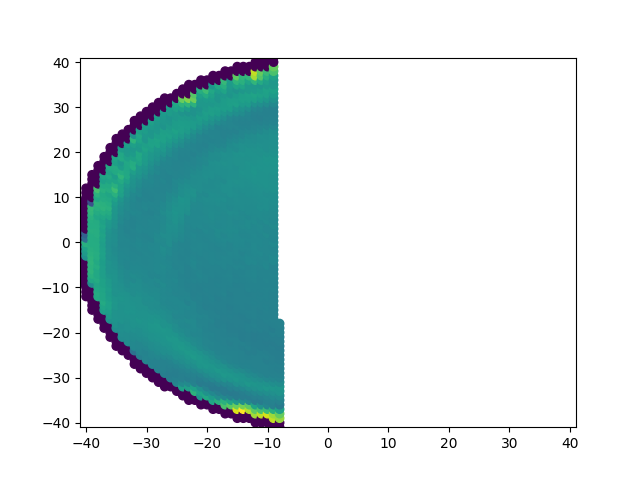

(-41.0, 41.0)

In [94]:
plt.figure()
plt.scatter(x,y,c=TTS)
plt.xlim(-41,41)
plt.ylim(-41,41)